<a href="https://colab.research.google.com/github/Dushxn/Deep-Learning-Project/blob/Shaini-Dev/Dl_PlantVillageMobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, pathlib, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# **Importing Plantvillage Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your zip file in Drive
zip_path = "/content/drive/MyDrive/DataSet/plantvillage.zip"

# Unzip into /content (fastest for Colab)
!unzip -q "$zip_path" -d /content/

# Check extracted folder name (sometimes it's "PlantVillage" or similar)
!ls /content

Mounted at /content/drive
 drive	'plantvillage dataset'	 sample_data


In [3]:
import os, pathlib

DATA_DIR = "/content/plantvillage dataset"   # change if the extracted folder name differs
assert os.path.exists(DATA_DIR), "Check folder name after unzip!"
print("Dataset root:", DATA_DIR)

Dataset root: /content/plantvillage dataset


## **Dataset Analysis**

inspect folder structure and counts

In [4]:
root = pathlib.Path(DATA_DIR)
# If dataset has 'train'/'test' folders or 'plant_village' etc, adapt this snippet.
# We'll assume images are organized in subfolders per class:
classes = [p.name for p in root.iterdir() if p.is_dir()]
classes = sorted(classes)
print(f"Found {len(classes)} classes.")
for c in classes[:30]:
    cnt = len(list(root.joinpath(c).glob('*')))
    print(f"{c}: {cnt} images")


Found 3 classes.
color: 38 images
grayscale: 38 images
segmented: 38 images


visualize class distribution (bar plot)

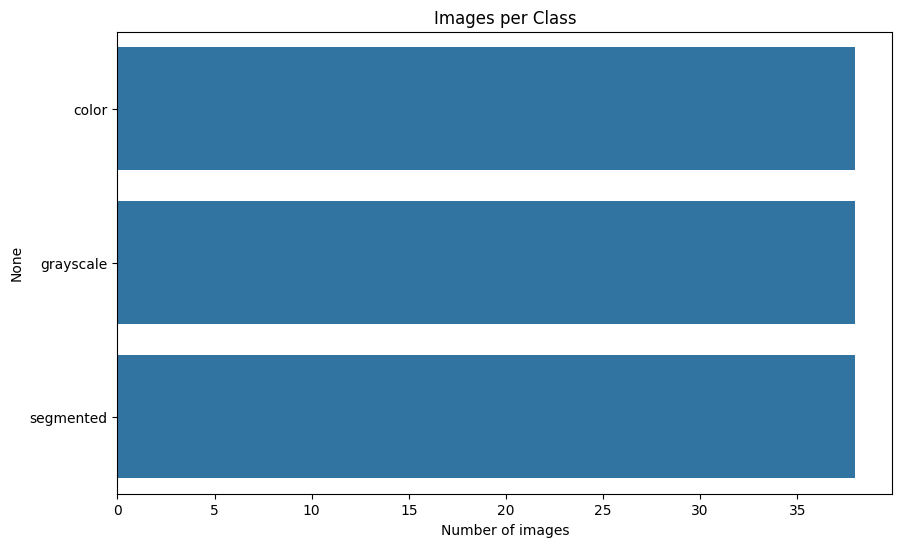

In [5]:
counts = {}
for c in classes:
    counts[c] = len(list(root.joinpath(c).glob('*')))
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=counts_df['count'].values, y=counts_df.index)
plt.title("Images per Class")
plt.xlabel("Number of images")
plt.show()


show sample images per class

In [6]:
import matplotlib.image as mpimg
def show_samples(classes, n_per_class=3, img_size=(224,224)):
    plt.figure(figsize=(n_per_class*3, len(classes)*3))
    i = 1
    for row, c in enumerate(classes):
        # Filter out directories and only include files
        imgs = [p for p in root.joinpath(c).glob('*') if p.is_file()][:n_per_class]
        for col, img_path in enumerate(imgs):
            ax = plt.subplot(len(classes), n_per_class, i)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            ax.set_title(c if col==0 else "")
            ax.axis('off')
            i += 1
    plt.tight_layout()
# show top 6 classes to avoid huge plot
show_samples(list(counts_df.index[:6]), n_per_class=4)

<Figure size 1200x900 with 0 Axes>

## **Data Preprocessing**

In [7]:
# Define key parameters
IMG_SIZE = (124, 124) # A standard size for many CNNs
BATCH_SIZE = 16

# Create the training dataset (80% of the data)
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123, # Seed for reproducibility
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Create the validation dataset (20% of the data)
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Get the class names (they are inferred in alphabetical order by the function)
class_names = train_ds.class_names
print("Class names:", class_names)

Found 162916 files belonging to 3 classes.
Using 130333 files for training.
Found 162916 files belonging to 3 classes.
Using 32583 files for validation.
Class names: ['color', 'grayscale', 'segmented']


Configuring for Performance

In [8]:
# This version streams from disk and uses much less RAM
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [9]:
# Create a data augmentation layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

Train Models Below

Import Required Libraries (extra)

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


🌿 Step 2 — Prepare Preprocessing Layer for MobileNet

MobileNetV2 expects inputs scaled between -1 and 1, so we’ll include that preprocessing layer.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


🌿 Step 3 — Build the MobileNetV2 Model (Lightweight CNN)

In [12]:
IMG_SHAPE = (124, 124, 3)

# Load pre-trained base model
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers (initially)
base_model.trainable = False

# Build the model
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)           # Use your augmentation layer
x = preprocess_input(x)
x = base_model(x, training=False)       # Ensure batchnorm layers are not updated
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()


/tmp/ipython-input-3016983550.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

🌿 Step 4 — Compile the Model

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


🌿 Step 5 — Train the Model

We’ll use EarlyStopping and ModelCheckpoint to save the best version.

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("mobilenet_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/20
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9642 - loss: 0.1023
Epoch 1: val_accuracy improved from -inf to 0.97839, saving model to mobilenet_best.h5


8146/8146 ━━━━━━━━━━━━━━━━━━━━ 236s 25ms/step - accuracy: 0.9642 - loss: 0.1023 - val_accuracy: 0.9784 - val_loss: 0.0465
Epoch 2/20
8145/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9758 - loss: 0.0596
Epoch 2: val_accuracy did not improve from 0.97839
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 213s 25ms/step - accuracy: 0.9758 - loss: 0.0596 - val_accuracy: 0.9770 - val_loss: 0.0521
Epoch 3/20
8145/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9779 - loss: 0.0549
Epoch 3: val_accuracy improved from 0.97839 to 0.97938, saving model to mobilenet_best.h5


8146/8146 ━━━━━━━━━━━━━━━━━━━━ 255s 24ms/step - accuracy: 0.9779 - loss: 0.0549 - val_accuracy: 0.9794 - val_loss: 0.0462
Epoch 4/20
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9780 - loss: 0.0531
Epoch 4: val_accuracy improved from 0.97938 to 0.98137, saving model to mobilenet_best.h5


8146/8146 ━━━━━━━━━━━━━━━━━━━━ 204s 24ms/step - accuracy: 0.9780 - loss: 0.0531 - val_accuracy: 0.9814 - val_loss: 0.0434
Epoch 5/20
8145/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9782 - loss: 0.0518
Epoch 5: val_accuracy did not improve from 0.98137
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 204s 24ms/step - accuracy: 0.9782 - loss: 0.0518 - val_accuracy: 0.9805 - val_loss: 0.0416
Epoch 6/20
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9789 - loss: 0.0505
Epoch 6: val_accuracy did not improve from 0.98137
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 201s 24ms/step - accuracy: 0.9789 - loss: 0.0505 - val_accuracy: 0.9802 - val_loss: 0.0457
Epoch 7/20
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9788 - loss: 0.0502
Epoch 7: val_accuracy improved from 0.98137 to 0.98183, saving model to mobilenet_best.h5


8146/8146 ━━━━━━━━━━━━━━━━━━━━ 202s 24ms/step - accuracy: 0.9788 - loss: 0.0502 - val_accuracy: 0.9818 - val_loss: 0.0435
Epoch 8/20
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9791 - loss: 0.0507
Epoch 8: val_accuracy did not improve from 0.98183
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 202s 24ms/step - accuracy: 0.9791 - loss: 0.0507 - val_accuracy: 0.9775 - val_loss: 0.0449
Epoch 9/20
8143/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9779 - loss: 0.0509
Epoch 9: val_accuracy did not improve from 0.98183
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 212s 25ms/step - accuracy: 0.9779 - loss: 0.0509 - val_accuracy: 0.9811 - val_loss: 0.0429
Epoch 10/20
8145/8146 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9788 - loss: 0.0513
Epoch 10: val_accuracy did not improve from 0.98183
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 202s 24ms/step - accuracy: 0.9788 - loss: 0.0513 - val_accuracy: 0.9803 - val_loss: 0.0461


🌿 Step 6 — Fine-Tuning (Optional but boosts accuracy)

After initial training, unfreeze some top layers to allow learning more plant-specific features.

In [15]:
base_model.trainable = True

# Fine-tune from this layer onward
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 379s 43ms/step - accuracy: 0.9505 - loss: 0.1728 - val_accuracy: 0.9804 - val_loss: 0.0407
Epoch 2/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 360s 43ms/step - accuracy: 0.9778 - loss: 0.0524 - val_accuracy: 0.9822 - val_loss: 0.0374
Epoch 3/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 369s 44ms/step - accuracy: 0.9810 - loss: 0.0426 - val_accuracy: 0.9832 - val_loss: 0.0351
Epoch 4/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 363s 43ms/step - accuracy: 0.9829 - loss: 0.0356 - val_accuracy: 0.9829 - val_loss: 0.0351
Epoch 5/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 372s 45ms/step - accuracy: 0.9831 - loss: 0.0322 - val_accuracy: 0.9824 - val_loss: 0.0353
Epoch 6/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 373s 45ms/step - accuracy: 0.9847 - loss: 0.0311 - val_accuracy: 0.9846 - val_loss: 0.0321
Epoch 7/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 365s 44ms/step - accuracy: 0.9842 - loss: 0.0292 - val_accuracy: 0.9834 - val_loss: 0.0332
Epoch 8/10
8146/8146 ━━━━━━━━━━━━━━━━━━━━ 357s 43ms/step - accuracy: 

🌿 Step 7 — Evaluate the Model

If you don’t have a separate test set, use the validation dataset for evaluation.

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")


🌿 Step 8 — Plot Accuracy and Loss Graphs

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


🌿 Step 9 — Predictions and Confusion Matrix

In [ ]:
# Convert val_ds into arrays
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🌿 Step 10 — Save the Model

In [ ]:
model.save("mobilenet_plant_disease_model.h5")
print("✅ Model saved as mobilenet_plant_disease_model.h5")


🌿 Step 11 — Optional: View Model Parameters

In [ ]:
trainable_count = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
non_trainable_count = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
print(f"Trainable params: {trainable_count:,}")
print(f"Non-trainable params: {non_trainable_count:,}")
